In [8]:
import numpy as np 
import time as t
import matplotlib.pyplot as plt
import sympy as sp
from numba import njit, prange

In [9]:
# Versão otimizada com Numba (JIT compilation)
# O decorator @njit compila o código para C, tornando muito mais rápido

@njit(parallel=True)
def retroSubstitution(A, b):
    n = len(b)
    x = np.zeros(n)
    for i in range(n-1, -1, -1):
        sum_ax = 0.0
        for j in range(i+1, n):
            sum_ax += A[i, j] * x[j]
        x[i] = (b[i] - sum_ax) / A[i, i]
    return x


@njit(parallel=True)
def gaussianElimination(A, b): 
    n = len(b)
    # Cria cópias para não modificar os originais
    A = A.copy()
    b = b.copy()
    
    for i in range(n): 
        # Encontra o pivô máximo
        max_val = abs(A[i, i])
        pivot_index = i
        for k in range(i+1, n):
            if abs(A[k, i]) > max_val:
                max_val = abs(A[k, i])
                pivot_index = k
        
        # Troca de linhas
        if pivot_index != i:
            for j in range(n):
                temp = A[i, j]
                A[i, j] = A[pivot_index, j]
                A[pivot_index, j] = temp
            temp_b = b[i]
            b[i] = b[pivot_index]
            b[pivot_index] = temp_b
        
        if A[i, i] == 0:
            raise ValueError("Singular matrix.")
        
        # Eliminação paralela (numba prange para paralelismo)
        for k in prange(i+1, n):
            multiplier = A[k, i] / A[i, i]
            for j in range(i, n):
                A[k, j] -= multiplier * A[i, j]
            b[k] -= multiplier * b[i]
    
    x = retroSubstitution(A, b)
    return x


# Teste rápido para compilar o código (JIT warmup)
print("Compilando funções com Numba (primeira execução)...")
_test_A = np.random.rand(100, 100)
_test_b = np.random.rand(100)
_ = gaussianElimination(_test_A, _test_b)
print("Compilação concluída!")

Compilando funções com Numba (primeira execução)...
Compilação concluída!


Atividade 2

Executando 10 eliminações gaussianas...
Tamanhos: [ 1000  2000  3000  4000  5000  6000  7000  8000  9000 10000]

n = 1000... Tempo: 0.11s
n = 2000... Tempo: 0.68s
n = 3000... Tempo: 3.94s
n = 4000... Tempo: 10.50s
n = 5000... Tempo: 23.35s
n = 6000... Tempo: 40.55s
n = 7000... Tempo: 64.07s
n = 8000... Tempo: 94.10s
n = 9000... Tempo: 135.50s
n = 10000... Tempo: 179.09s

Tempo total: 551.88 segundos
Tempo médio de execução: 55.19 segundos


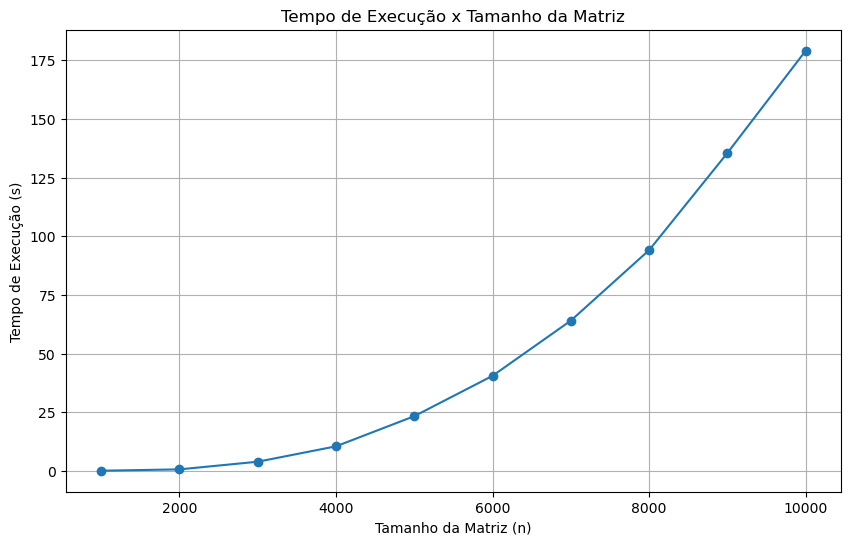

[ 1000  2000  3000  4000  5000  6000  7000  8000  9000 10000]


In [10]:
eliminations = 10
n_values = np.linspace(1000, 10000, eliminations, dtype=int)
times = np.zeros(eliminations)
total_time = 0
k = 0
solutions = []

print(f"Executando {eliminations} eliminações gaussianas...")
print(f"Tamanhos: {n_values}\n")

for i in n_values:
    print(f"n = {i}...", end=" ", flush=True)
    A = np.random.rand(i, i)
    b = np.random.rand(i)

    start_time = t.time()
    solution = gaussianElimination(A, b)
    end_time = t.time()
    times[k] = end_time - start_time
    total_time += times[k]
    print(f"Tempo: {times[k]:.2f}s")
    k += 1
    solutions.append(solution)  
    
average_time = total_time / eliminations

print(f"\nTempo total: {total_time:.2f} segundos")
print(f"Tempo médio de execução: {average_time:.2f} segundos")


plt.figure(figsize=(10, 6))
plt.plot(n_values, times, marker='o')
plt.title('Tempo de Execução x Tamanho da Matriz')
plt.xlabel('Tamanho da Matriz (n)')
plt.ylabel('Tempo de Execução (s)')
plt.grid()
plt.show()
print(n_values)

Exercício 3

Coeficientes encontrados:
c0 = 1.0568333253756524e-11, c1 = 3.3201474281353547

Expressão ajustada: 


Eq(T(n), 1.05683e-11*n**3.32015)

coeficientes via NumPy:  
c0 = 0.000000, c1 = 3.320147


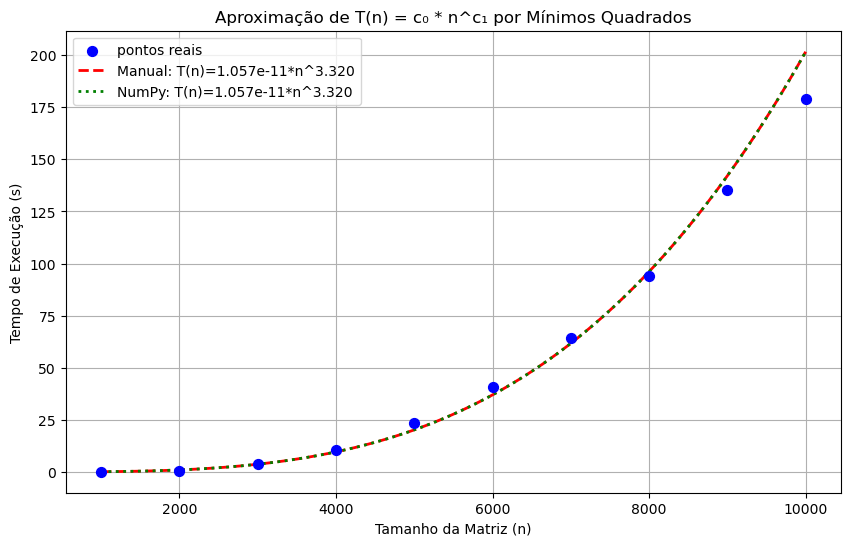

In [11]:
# Aproximação de T(n) = c0 * n^c1 usando linearização logarítmica
x_values = np.array(n_values)
y_values = np.array(times)  # Tempos de execução

# log(T) = log(c0) + c1*log(n)
log_x = np.log(x_values)
log_y = np.log(y_values)

# linear pois já é logaritmo
grau = 1  

# matriz de vandermonde
n_size = len(log_x)
V = np.zeros((n_size, grau + 1))
for i in range(n_size):
    for j in range(grau + 1):
        V[i, j] = log_x[i] ** j


A = np.dot(V.T, V)
b = np.dot(V.T, log_y)


c_manual = gaussianElimination(A, b)
log_c0 = c_manual[0]  # c0 log
c1 = c_manual[1]      # c1 normal
c0 = np.exp(log_c0)   # c0 = e^(log_c0)

print(f"Coeficientes encontrados:\nc0 = {c0}, c1 = {c1}\n")


c0_rounded = float(f"{c0:.6g}")  
c1_rounded = float(f"{c1:.6g}")         

# só pra apresentar melhor
n = sp.symbols('n')
T = sp.Function('T')
T_n = c0_rounded * n**c1_rounded

print("Expressão ajustada: ")
display(sp.Eq(T(n), T_n))

# comparação com np.polyfit
coef_numpy = np.polyfit(log_x, log_y, 1)
c1_numpy = coef_numpy[0]
c0_numpy = np.exp(coef_numpy[1])
print(f"coeficientes via NumPy:  \nc0 = {c0_numpy:.6f}, c1 = {c1_numpy:.6f}")


x_fit = np.linspace(min(x_values), max(x_values), 100)
y_manual = c0 * (x_fit ** c1)
y_numpy = c0_numpy * (x_fit ** c1_numpy)

plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, label='pontos reais', color='blue', s=50, zorder=3)
plt.plot(x_fit, y_manual, label=f'Manual: T(n)={c0:.3e}*n^{c1:.3f}', linestyle='--', color='red', linewidth=2)
plt.plot(x_fit, y_numpy, label=f'NumPy: T(n)={c0_numpy:.3e}*n^{c1_numpy:.3f}', linestyle=':', color='green', linewidth=2)
plt.title('Aproximação de T(n) = c₀ * n^c₁ por Mínimos Quadrados')
plt.xlabel('Tamanho da Matriz (n)')
plt.ylabel('Tempo de Execução (s)')
plt.legend()
plt.grid()
plt.show()
